<a href="https://colab.research.google.com/github/jjhooon/Vehicle-Intelligence/blob/main/Intrinsic_Extrinsic_Parameter_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intrinsic/Extrinsic Parameter estimation

국민대학교 차량지능기초 SLAM 파트 과제 3

- 학번 : 20163327
- 이름 : 장재훈

---

OpenCV를 사용해 여러 장의 체스 보드 이미지에 대한 카메라의 내부/외부 파라미터를 구한다.

---

**[중요] 과제 제출 방법**
- 과제 제출 기한은 2021년 6월 9일까지입니다.
- 과제는 Colab에서 작성한 것을 다운받아 (파일-.ipynb 다운로드) 가상 대학에 업로드합니다. (이외의 제출 방법은 인정하지 않음)
- 제출 시 파일 제목은 '학번_이름' 으로 저장합니다.

In [ ]:
import sys
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob

print('python', sys.version)
print('numpy', np.__version__)
print('opencv', cv.__version__)

python 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]
numpy 1.19.5
opencv 4.1.2


## Google Drive와 연동하기


In [ ]:
# mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!ls '/content/drive/MyDrive/Colab Notebooks/vehicle intelligence/img/calib'

left01.jpg  left04.jpg	left07.jpg  left11.jpg	left14.jpg
left02.jpg  left05.jpg	left08.jpg  left12.jpg	pattern.png
left03.jpg  left06.jpg	left09.jpg  left13.jpg


In [ ]:
ROOT = '/content/drive/MyDrive/Colab Notebooks/vehicle intelligence/img/calib/'

### 이미지 불러오기

좋은 결과를 위해 최소 10장의 사진이 준비되어야 한다.

13


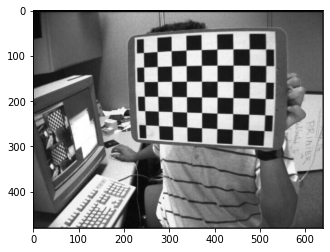

In [ ]:
images = []
image_files = glob.glob(ROOT + '*.jpg')


for f in image_files :
  img = cv.imread(f)
  images.append(img)

print(len(images))
plt.imshow(images[0][:,:,::-1])
plt.show()

## 체스 보드 코너 찾기




관련 함수

- `	retval, corners	=	cv.findChessboardCorners(	image, patternSize[, corners[, flags]]	)`
- `corners	=	cv.cornerSubPix(	image, corners, winSize, zeroZone, criteria`
- `	image	=	cv.drawChessboardCorners(	image, patternSize, corners, patternWasFound	)`



**과제**

- 관련 함수들에 대한 입력과 출력, 파라미터를 조사해 서술한다.
- 관련 함수들을 사용하여 체스 보드의 코너를 찾는 함수 `findCorner()`를 완성한다. `findCorner()` 함수의 입력과 출력은 다음과 같다.
  - 입력 : 코너를 찾을 체스 보드의 이미지
  - 출력
    - ret : 함수의 성공 여부
    - corner_refine : `cv.cornerSubPix()`를 통해 개선된 코너점
    - corner_img : 찾은 코너와 원본 이미지를 합성한 이미지


**참고**

- 주어진 체스 보드는 9x6 grid이다.




**1) cv.findChessboardCorners 함수**

cv.findChessboardCorners 함수는 4가지 parameter를 가지고 있고, 각각에 대한 설명은 다음과 같다.

- images : 8bit grayscale의 체스보드 이미지
- patternSize : 체스보드의 행과 열당 inner corner의 개수
- corners : 발견된 코너의 결과 array
- flags : 다양한 옵션(ex : CALIB_CB_ADAPTIVE_THRESH, CALIB_CB_NORMALIZE_IMAGEM, CALIB_CB_FILTER_QUADS, CALIB_CB_FAST_CHECK)

이미지가 코너 포인트를 가지고 있으면 non-zero value를 return한다. 이러한 코너들은 row by row, left to right 순서로 위치하게 된다. 반면, 코너를 찾지 못하면 0을 return한다. 

**2) cv.cornerSubPix 함수**

cv.findChessboardCorners 함수를 통해 얻은 corner들의 좌표가 대략적이다. 따라서, cv.cornerSubPix 함수를 이용하여 corner 위치의 정확도를 향상시킬 수 있다.

cv.cornerSubPix 함수는 5가지 parameter를 가지고 있고, 각각에 대한 설명은 다음과 같다.

- image : single channel, 8bit의 이미지
- corners : 입력 corner의 초기 좌표 및 결과 출력을 위해 제공된 정제된 좌표
- winSize : 검색창 측면 길이의 절반, 만약 winSize를 5로 설정하면 검색창의 크기는 11x11이 된다.
- zeroZone : 검색 영역 중간에 있는 dead region 크기의 절반으로 공식의 합산이 이루어지지 않는다. zeroZone은 autocorrelation matrix의 가능한 특이성을 피하기 위하여 가끔 사용된다. zeroZone의 값을 (-1,1)로 설정하면 크기가 없음을 의미한다.
- criteria : corner refinement과정의 반복을 종료하는 기준이다. 즉, corner position refinement는 criteria.maxCount가 지난 후나 corner position이 criteria.eplison보다 작게 움직일 때 종료된다.

refinement된 코너의 위치를 결과로 출력한다.

**3) cv.drawChessboardCorners 함수**

cv.drawChessboardCorners함수는 4가지 parameter를 가지고 있고, 각각에 대한 설명은 다음과 같다.

- image : 8bit color의 최종 이미지
- patternSize : 체스보드의 행과 열당 inner corner의 개수
- corners : findChessboardCorners의 output인 발견된 코너의 array
- patternWasFound : findChessboardCorner의 retval이 전달된다. complete board가 찾아졌는지 아닌지를 알려주는 parameter이다.

결과 이미지를 출력한다. 코너가 찾지 못하면 빨간 원을 그리고, 코너를 찾으면 색칠된 코너를 선으로 연결한다.



In [ ]:
w = 6
h = 9

# Prepare object points, like(0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
xval, yval = np.arange(h), np.arange(w) # w, h 크기의 배열을 만든다.
objp = np.meshgrid(xval, yval, 0.) # w,h 크기의 배열을 이용하여 직사각형 격자를 생성한다. 
objp = np.concatenate(objp, axis=2) # 열방향으로 concatenate
objp = objp.reshape(-1,3) # objp를 3열, 행은 자동으로 reshape
objp = objp.astype(np.float32) #objp 배열을 float형태로 변환한다. 

In [ ]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001) #refinement 종료 기준

def findCorner(img) :
  
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) # findChessboardCorners함수는 gray scale을 인자로 받기 때문에 변환

  ret, corners = cv.findChessboardCorners(gray,(9,6), None)
  corner_refine = cv.cornerSubPix(gray, corners, (5,5), (-1,-1), criteria)
  corner_img = cv.drawChessboardCorners(img, (9,6), corner_refine, ret)

  return ret, corner_refine, corner_img

In [ ]:
# 이 부분은 수정하지 않습니다. 

objpoints = [] # 실제 세계의 3D 포인트들
imgpoints = [] # 이미지 평면 상의 2D 포인트들
corner_imgs = [] # 이미지 합성 결과를 저장

for img in images : 
  
  ret, corner, corner_img = findCorner(img)

  if ret == True :
    objpoints.append(objp)
    imgpoints.append(corner)
    corner_imgs.append(corner_img)

### 찾은 코너 시각화

13


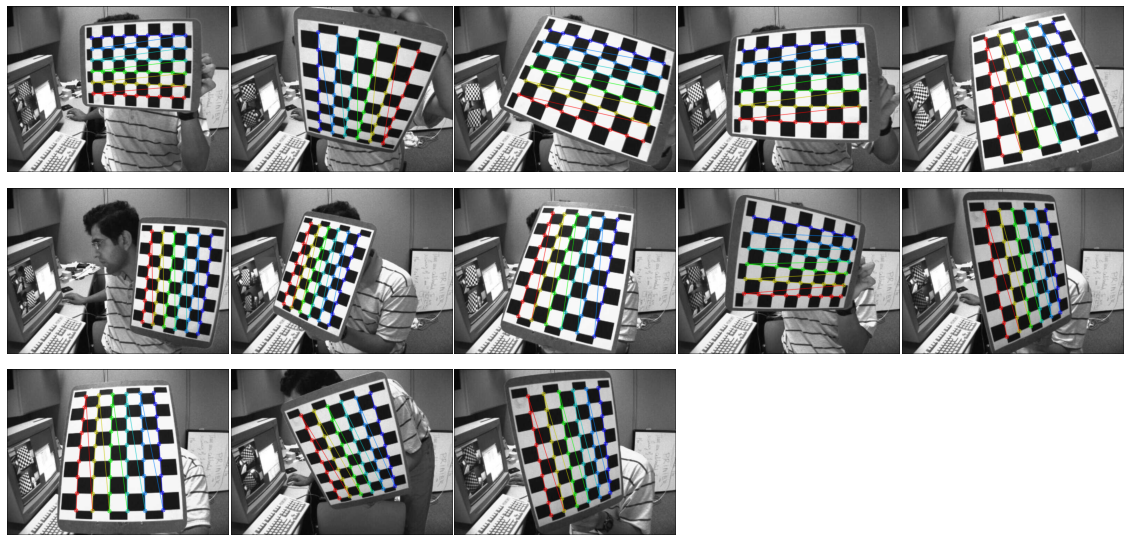

In [ ]:
# 이 부분은 수정하지 않습니다. 

from matplotlib.gridspec import  GridSpec
print(len(corner_imgs))

nrows = 3
ncols = 5

fig = plt.figure(figsize = (20,10))
grid = GridSpec(nrows, ncols, wspace=0.01, hspace=0.0)

for i, img in enumerate(corner_imgs) :
  ax = plt.subplot(grid[i])
  ax.axis('off')
  ax.imshow(img)

## Calibration 

찾은 코너 포인트를 이용해 카메라의 내부/외부 파라미터를 찾는다.

**과제** 

- 카메라 매트릭스와 회전/이동 벡터들을 구한다.

관련 함수 

- `cv.calibrateCamera`

In [ ]:
# To-do : cam_matrix, rotation_vectors, translation_vectors를 찾기

images_cal = []
image_files = glob.glob(ROOT + '*.jpg')

for f in image_files :
  img_cal = cv.imread(f)
  gray_cal = cv.cvtColor(img_cal, cv.COLOR_BGR2GRAY)
  images_cal.append(gray_cal)

# 카메라의 내부 / 외부 파라미터를 찾기 위하여 cv.calibrateCamera 함수를 사용한다.
ret, cam_matrix, dist, rotation_vectors, translation_vectors = cv.calibrateCamera(objpoints, imgpoints, gray_cal.shape[::-1], None, None )

In [ ]:
# 이 부분은 수정하지 않습니다. 

print('camera matrix \n', cam_matrix) 
print('rotation vectors \n', rotation_vectors)
print('translation vectors \n', translation_vectors)

camera matrix 
 [[532.82709963   0.         342.48678133]
 [  0.         532.94587936 233.85595303]
 [  0.           0.           1.        ]]
rotation vectors 
 [array([[0.16637908],
       [0.27440615],
       [0.01309232]]), array([[ 0.41702592],
       [ 0.65494957],
       [-1.33660599]]), array([[-0.28001223],
       [ 0.18689495],
       [ 0.35483997]]), array([[-0.11424218],
       [ 0.23777544],
       [-0.0024294 ]]), array([[-0.29490667],
       [ 0.42955596],
       [ 1.31246712]]), array([[0.40484003],
       [0.30590267],
       [1.64832325]]), array([[0.17461283],
       [0.34624931],
       [1.86814082]]), array([[-0.09367173],
       [ 0.4815123 ],
       [ 1.75273923]]), array([[ 0.19951409],
       [-0.42541742],
       [ 0.13305708]]), array([[-0.42158004],
       [-0.49716686],
       [ 1.33662043]]), array([[-0.24158311],
       [ 0.34849022],
       [ 1.53043258]]), array([[ 0.46476464],
       [-0.28442293],
       [ 1.2390508 ]]), array([[-0.17325293],
       [

**과제**

- 아래 링크를 참고하여 얻어낸 camera matrix, rotation and translation vector를 이용해 이미지 상에 3D 축을 그린다.
- https://docs.opencv.org/master/d7/d53/tutorial_py_pose.html

In [ ]:
# To-do
# 이미지 위에 축을 그리는 draw 함수를 정의한다. 
def draw(img, corners, imgpts):
  corner = tuple(corners[0].ravel())
  img = cv.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
  img = cv.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
  img = cv.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
  return img

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)

axis_imgs = [] #3D 축을 그린 이미지를 넣을 list

# 3D points를 image에 투영시키기 위하여 cv.projectPoints 함수를 사용한다.
for i in range(len(rotation_vectors)):
  imgpts, jac = cv.projectPoints(axis, rotation_vectors[i], translation_vectors[i], cam_matrix, dist)
  axis_img = draw(images[i], imgpoints[i], imgpts)
  axis_imgs.append(axis_img)

13


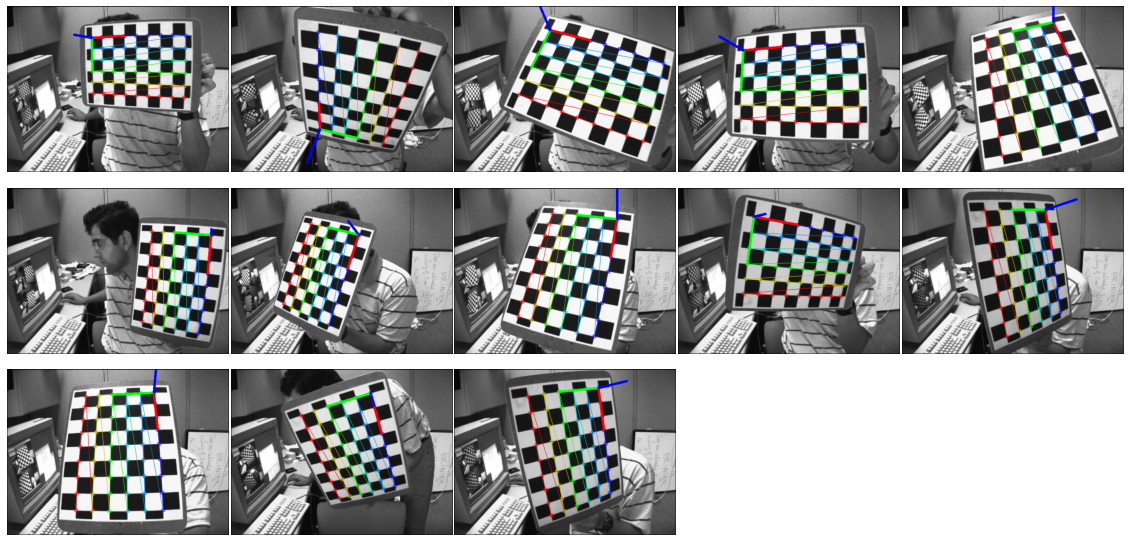

In [ ]:
from matplotlib.gridspec import GridSpec
print(len(axis_imgs))

nrows = 3
ncols = 5

fig = plt.figure(figsize = (20,10))
grid = GridSpec(nrows, ncols, wspace=0.01, hspace=0.0)

for i, img in enumerate(axis_imgs) :
  ax = plt.subplot(grid[i])
  ax.axis('off')
  ax.imshow(img)

## 추가 점수 과제

직접 찍은 체스 보드 이미지를 사용해 위 과정을 똑같이 수행한다.
  - 체스 보드는 첨부된 이미지(pattern.png), 직접 그린/다운로드한 이미지 등을 출력해 사용한다.

12


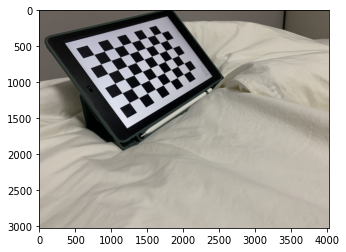

In [ ]:
ROOT2 = '/content/drive/MyDrive/Colab Notebooks/vehicle intelligence/img/mycalib/'

images = []
image_files = glob.glob(ROOT2 + '*.jpg')

for f in image_files :
  img = cv.imread(f)
  images.append(img)

print(len(images))
plt.imshow(images[0][:,:,::-1])
plt.show()

w = 6
h = 9

# Prepare object points, like(0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
xval, yval = np.arange(h), np.arange(w) 
objp = np.meshgrid(xval, yval, 0.)
objp = np.concatenate(objp, axis=2) 
objp = objp.reshape(-1,3) 
objp = objp.astype(np.float32)

In [ ]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

def findCorner(img) :
  
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

  ret, corners = cv.findChessboardCorners(gray,(9,6), None)
  corner_refine = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
  corner_img = cv.drawChessboardCorners(img, (9,6), corner_refine, ret)

  return ret, corner_refine, corner_img

In [ ]:
objpoints = [] # 실제 세계의 3D 포인트들
imgpoints = [] # 이미지 평면 상의 2D 포인트들
corner_imgs = [] # 이미지 합성 결과를 저장

for img in images : 
  
    ret, corner, corner_img = findCorner(img)

    if ret == True :
        objpoints.append(objp)
        imgpoints.append(corner)
        corner_imgs.append(corner_img)

12


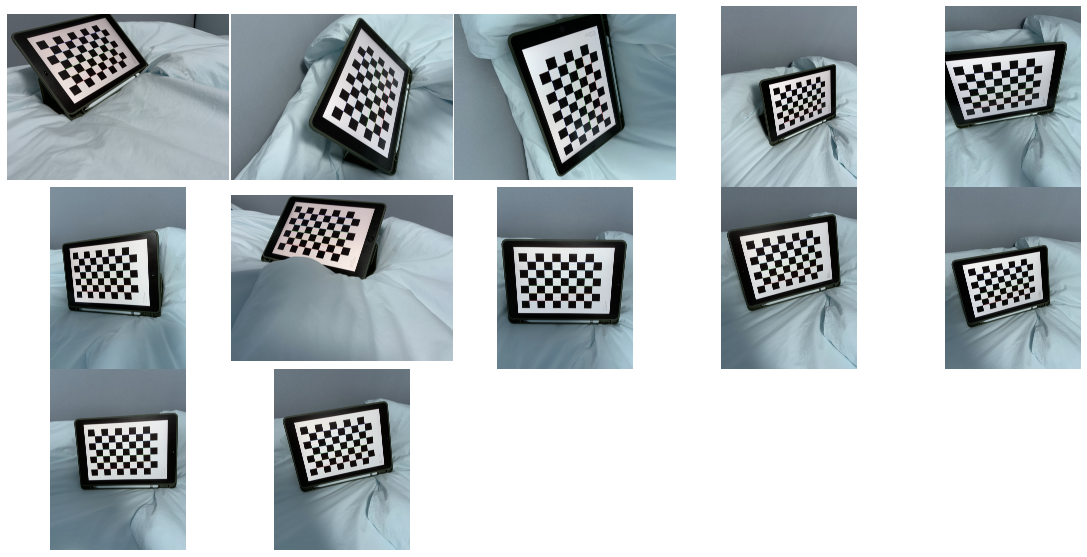

In [ ]:
from matplotlib.gridspec import  GridSpec
print(len(corner_imgs))

nrows = 3
ncols = 5

fig = plt.figure(figsize = (20,10))
grid = GridSpec(nrows, ncols, wspace=0.01, hspace=0.0)

for i, img in enumerate(corner_imgs) :
  ax = plt.subplot(grid[i])
  ax.axis('off')
  ax.imshow(img)

In [ ]:
images_cal = []
image_files = glob.glob(ROOT2 + '*.jpg')

for f in image_files :
  img_cal = cv.imread(f)
  gray_cal = cv.cvtColor(img_cal, cv.COLOR_BGR2GRAY)
  images_cal.append(gray_cal)

ret, cam_matrix, dist, rotation_vectors, translation_vectors = cv.calibrateCamera(objpoints, imgpoints, gray_cal.shape[::-1], None, None )

print('camera matrix \n', cam_matrix) # cam_matrix는 3x3 형태
print('rotation vectors \n', rotation_vectors) # rotation vectors는 3x1 형태
print('translation vectors \n', translation_vectors) # translation vectors는 3x1 형태

camera matrix 
 [[2.75999276e+03 0.00000000e+00 1.62483751e+03]
 [0.00000000e+00 2.80483301e+03 1.78765414e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
rotation vectors 
 [array([[-0.22629141],
       [-0.51623943],
       [-0.60684795]]), array([[ 0.10341984],
       [-0.57181965],
       [-1.047295  ]]), array([[ 0.59153192],
       [-0.09009475],
       [-1.94329402]]), array([[ 0.25349239],
       [-0.50989937],
       [-0.16874957]]), array([[ 0.5900659 ],
       [-0.22697039],
       [-0.07092667]]), array([[ 0.08916469],
       [ 0.30070949],
       [-0.0570979 ]]), array([[-0.19951349],
       [ 0.31210008],
       [ 0.31994379]]), array([[ 0.22829944],
       [-0.03683609],
       [ 0.01353391]]), array([[ 0.23541896],
       [-0.24800287],
       [-0.19419229]]), array([[ 0.26290773],
       [-0.2803517 ],
       [-0.15464211]]), array([[ 0.19148295],
       [ 0.04585977],
       [-0.0431026 ]]), array([[ 0.22572613],
       [-0.15128356],
       [-0.17595828]])]
tra

12


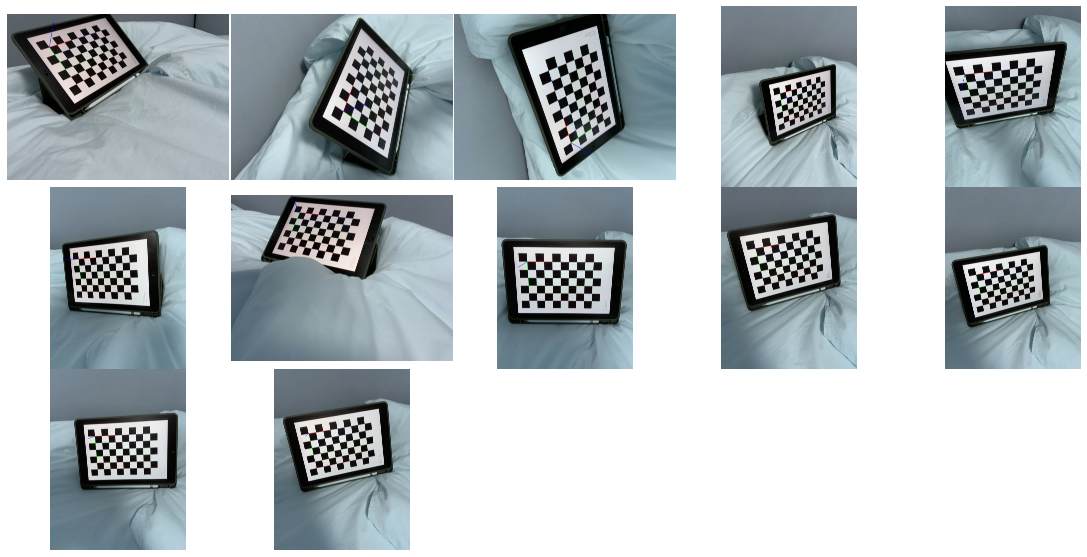

In [ ]:
def draw(img, corners, imgpts):
  corner = tuple(corners[0].ravel())
  img = cv.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
  img = cv.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
  img = cv.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
  return img

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)

axis_imgs = [] 

for i in range(len(rotation_vectors)):
  imgpts, jac = cv.projectPoints(axis, rotation_vectors[i], translation_vectors[i], cam_matrix, dist)
  axis_img = draw(images[i], imgpoints[i], imgpts)
  axis_imgs.append(axis_img)

from matplotlib.gridspec import GridSpec
print(len(axis_imgs))

nrows = 3
ncols = 5

fig = plt.figure(figsize = (20,10))
grid = GridSpec(nrows, ncols, wspace=0.01, hspace=0.0)

for i, img in enumerate(axis_imgs) :
  ax = plt.subplot(grid[i])
  ax.axis('off')
  ax.imshow(img)